In [13]:
import numpy as np
import gudhi as gd
import pandas as pd
import gudhi.representations
import matplotlib.pyplot as plt
import csv
import os
import heapq

In [53]:
dgms, labels = [], []

directory = '/Users/ryanhuang/Downloads/csv/'
files = os.listdir(directory)
df = pd.read_csv("patient-subtype.csv")

for filename in files:
    df2 = df.loc[df['Patient_ID'] == filename[0:12], 'Subtype']
    if df2.isin(["BRCA_Basal"]).any():
        labels.append(0)
    elif df2.isin(["BRCA_Her2"]).any():
        labels.append(1)
    elif df2.isin(["BRCA_LumA"]).any():
        labels.append(2)
    elif df2.isin(["BRCA_LumB"]).any():
        labels.append(3)
    else:
        continue
    f = os.path.join(directory, filename)
    X = np.loadtxt(f, delimiter=',')
    ac = gd.AlphaComplex(points=X).create_simplex_tree(max_alpha_square=1e12)
    d = ac.persistence()
#     dgms.append(ac.persistence_intervals_in_dimension(1))
    LS = gd.representations.Landscape(resolution=1000)
    dgm = LS.fit_transform([ac.persistence_intervals_in_dimension(1)])
    dgms.append(dgm[0][:1000]) # diagram includes all 5000 points
    
dgms1=np.array(dgms)

In [54]:
test_size            = 0.2
perm                 = np.random.permutation(len(labels))
limit                = int(test_size * len(labels))
test_sub, train_sub  = perm[:limit], perm[limit:]
train_labs           = np.array(labels)[train_sub]
test_labs            = np.array(labels)[test_sub]
train_dgms           = [dgms[i] for i in train_sub]
test_dgms            = [dgms[i] for i in test_sub]
print(np.array(train_labs))

[3 0 2 2 0 3 2 0 2 1 2 2 2 3 2 3 2 2 3 0 2 2 2 2 3 0 2 2 3 2 1 2 3 2 3 0 2
 0 2 2 2 2 3 3 1 2 2 0 2 2 2 2 1 2 0 2 3 2 2 1 3 3 2 2 2 3 1 2 0 3 2 2 0 2
 0 2 2 2 3 2 2 2 3 0 2 3 1 2 0 2 2 1 2 3 0 0 3 1 3 2 2 3 2 2 2 2 2 2 2 2 3
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 3 2 0 2 2 2 3 2 1 2 1 3 2 1 2 2 0 1 2 2 0 1
 2 3 2 0 2 2 3 2 2 2 2 0 3 2 0 3 2 0 2 2 2 2 3 2 0 2 2 2 2 2 2 2 1 2 2 2 2
 2 2 3 2 2 2 2 2 2 2 0 2 0 2 2 2 3 2 3 2 3 3 2 3 2 2 2 2 2 3 2 3 2 2 2 1 2
 2 2 2 3 0 2 0 2 3 2 1 2 2 2 3 2 2 2 2 2 2 2 3 0 2 0 2 2 2 2 2 3 2 3 2 0 3
 2 2 2 2 2 2 2 1 2 1 0 0 3 2 3 2 1 2 0 2 2 0 0 2 0 3 0 2 1 0 0 3 3 0 3 2 2
 2 0 0 2 2 2 2 3 3 2 2 1 0 2 0 3 0 0 2 0 2 2 2 2 0 1 3 2 2 3 0 3 1 2 0 2 2
 2 2 1 0 0 2 2 2 1 2 0 3 3 2 2 2 3 2 0 3 2 2 2 0 1 2 0 2 2 2 0 2 2 0 2 0 2
 2 1 1 3 2 2 2 3 3 2 2 2 1 0 3 0 2 2 3 3 3 2 3 3 0 0 3 0 2 2 2 2 3 2 1 2 2
 2 2 0 2 2 3 3 2 3 0 2 3 2 2 2 3 3 0 1 3 2]


In [56]:
from sklearn.ensemble import RandomForestClassifier

feature_names = [f"feature {i}" for i in range(dgms1.shape[1])]
forest = RandomForestClassifier(random_state=0)
forest.fit(train_dgms, train_labs)

RandomForestClassifier(random_state=0)

In [57]:
import time

import numpy as np

start_time = time.time()
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.013 seconds


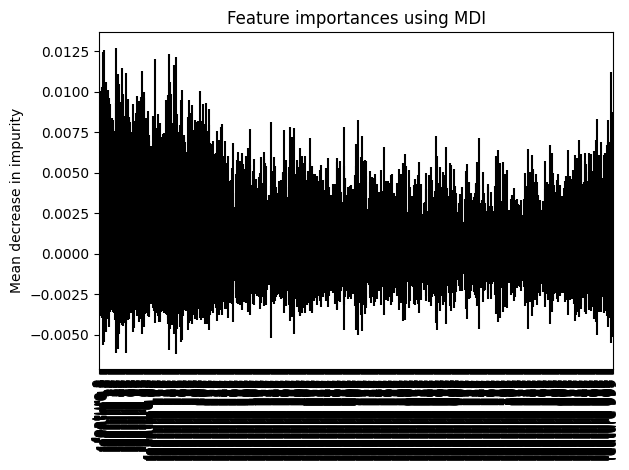

In [58]:
import pandas as pd

forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

Text(0, 0.5, 'Scores')

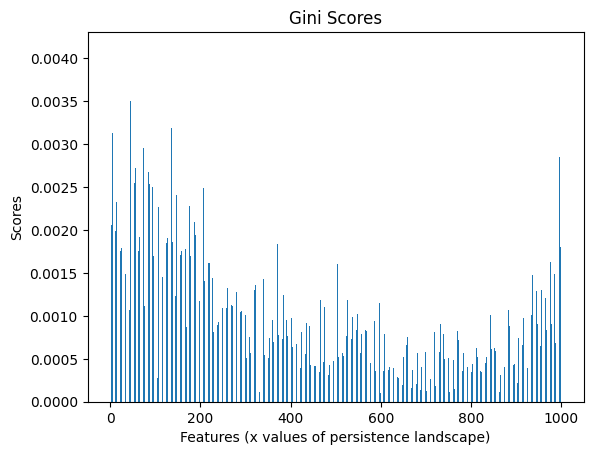

In [69]:
importances = list(forest_importances)
plt.bar([i for i in range(len(importances))], importances,
        width = 0.4)
plt.title('Gini Scores')
plt.xlabel('Features (x values of persistence landscape)')
plt.ylabel('Scores')